<a href="https://colab.research.google.com/github/machlovi/Spock-paper/blob/main/X_hate_and_offensive_data_combine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This file uses HateXplain data
We are initailizing 2 vector space for 3 classes in this code. Main idea is to visualize how we can separate words related to each classes in the given space

In [1]:
# ! apt-get install git

# Import Libraries

In [2]:
!pip install transformers --quiet

In [3]:
import os
import random
import pickle
from timeit import default_timer as timer
from tqdm import tqdm, trange

import re
import nltk
nltk.download("punkt")
from nltk.corpus import stopwords
nltk.download("stopwords")
from string import punctuation

import pandas as pd
pd.set_option("display.max_rows",20)
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.utils import class_weight
from sklearn.manifold import TSNE


from transformers import TFAutoModel, BertTokenizerFast, BertModel
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks as cb
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.constraints import MaxNorm
import keras
from keras.layers import Input, Concatenate, Flatten, Embedding, Dense, Dropout, LSTM
from keras.models import Model, Sequential
from keras.layers import Lambda

[nltk_data] Downloading package punkt to
[nltk_data]     /home/naseem_fordham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/naseem_fordham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/naseem_fordham/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:


#  Looking for GPU using by this kernel
              
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Specify the GPU you want to use

# import tensorflow as tf

# Check if TensorFlow is using GPU
if tf.test.gpu_device_name():
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
    print("No GPU devices found. TensorFlow is using CPU.")


Default GPU Device: /device:GPU:0


https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data#Data import

Data Source "https://github.com/t-davidson/33 ##
hate-speech-and-offensive-language/blob/master/data/readme.md"
'''hate_speech = number of CF users who judged the tweet to be hate speech.
offensive_language = number of CF users who judged the tweet to be offensive.
neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.
class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither'''



### Hate and offesive data

In [5]:
pwd

'/home/naseem_fordham/Spock-paper'

In [6]:
df_data1=pd.read_csv("/home/naseem_fordham/Spock-paper/data/HS_offensive.csv")

df_data1['class'].unique()
# df_peace=df_data1[df_data1['class']==2]
# df_peace=df_peace[['class','tweet']].reset_index(drop=True)
# df_hate=df_data1[(df_data1['class']==0) | (df_data1['class']==1)]

# df_hate=df_data1[(df_data1['class']==0) | (df_data1['class']==1)]
# df_hate=df_hate[['class','tweet']].reset_index(drop=True)
# df_hate['class']=1
# df_peace['class']=0




array([1, 0])

In [7]:
# df_peace['class'].unique()

### Xhate-999 data set
Class 1 hate, Class 0 non-hate speech

In [8]:
# @title
# # Use this part for single file
# # Define the path to your text file
# file_path = "/gdrive/MyDrive/SPOCK/Dataset/xhate-main/train/XHate999-EN-Gao-train.txt"

# # Initialize empty lists to store data
# tweets = []
# labels = []

# # Read the file line by line
# with open(file_path, 'r') as file:
#     for line in file:
#         # Split the line into text and label using the last character
#         line = line.strip()  # Remove leading/trailing whitespace
#         text = line[:-2].strip()  # Extract text (excluding the last character)
#         label = line[-1]  # Extract the label (as an integer)

#         # Append data to lists
#         tweets.append(text)
#         labels.append(label)

# # Create a DataFrame from the lists
# df = pd.DataFrame({'Text': tweets, 'Label': labels})
# df.drop(0,inplace=True)

# # Display the DataFrame
# print(df)


In [9]:
# import os
# import glob

# # Define the directory path where your text files are located
# directory_path = "/gdrive/MyDrive/SPOCK/Dataset/xhate-main/train"

# # Initialize empty lists to store data
# tweets = []
# labels = []

# # Loop through all text files in the specified directory
# for filename in glob.glob(os.path.join(directory_path, '*.txt')):
#     with open(filename, 'r') as file:

#       for line in file:
#           # Split the line into text and label using the last character
#           line = line.strip()  # Remove leading/trailing whitespace
#           text = line[:-2].strip()  # Extract text (excluding the last character)
#           label = line[-1]  # Extract the label (as an integer)

#           # Append data to lists
#           tweets.append(text)
#           labels.append(label)

# # Create a DataFrame from the lists
# df = pd.DataFrame({'tweet': tweets, 'class': labels})
# df.drop(0,inplace=True)


# df['class']=pd.to_numeric(df['class'], errors='coerce')
# df['class'].fillna(0, inplace=True)
# df['class']=df['class'].astype(int)
# df_hate2=df[df['class']==1]
# df_nonhate2=df[df['class']==0]

##Combing hatespeech and xhate data for hate/offensive class

In [10]:
def text_preprocessing(text,                                                               # text is a word string ex. 'rahul in ny'
                      punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~='ã¶``''',
                      stop_words = set(stopwords.words("english"))) -> list:

        '''
        A method to preprocess text

        '''

        for x in text.lower():
            if x in punctuations:
                text = text.replace(x,"")

        # removing words that have numbers in them
        text = re.sub(r'\w*\d\w*', '', text)
        # remove digits
        text = re.sub(r'[0-9]+', ' ', text)

        # clean the whitespaces

        text = re.sub(r'\s+', ' ', text).strip()



        # convert all text to a list

        # text = text.split(' ').  # uncomment if list required
        emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                  "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text) # no emoji

        # lowercase eth

        text = text.lower()


        # drop the stop words



        # add the tags

        return text

# HateXplain Dataset
Hate speech is a challenging issue plaguing the online social media. While better models for hate speech detection are continuously being developed, there is little research on the bias and interpretability aspects of hate speech. In this work, we introduce HateXplain, the first benchmark hate speech dataset covering multiple aspects of the issue. Each post in our dataset is annotated from three different perspectives: the basic, commonly used 3-class classification (i.e., hate, offensive or normal), the target community (i.e., the community that has been the victim of hate speech/offensive speech in the post), and the rationales

In [11]:
## HateXplain Dataset
HateXplain = pd.read_csv('/home/naseem_fordham/Spock-paper/data/Hate_Xplain.csv')
HateXplain["label"] = HateXplain["label"].apply(lambda x: 1.0 if x == "hatespeech" else (2.0 if x == "offensive" else 0.0))

HateXplain["text"] = HateXplain["text"].apply(lambda x : text_preprocessing(x))
HateXplain = HateXplain.sample(frac = 1).reset_index(drop = True)
HateXplain.rename(columns={"text":"tweet","label":"class"},inplace=True)
dataframe=HateXplain
# dataframe['class'].unique()

In [12]:
# df_hate_combine=pd.concat([df_hate,df_hate2]).reset_index(drop=True)
# df_nonhat_combine=pd.concat([df_peace,df_nonhate2]).reset_index(drop=True)

In [13]:
# df_hate_combine["tweet"] = df_hate_combine["tweet"].apply(lambda x : text_preprocessing(x))
# df_nonhat_combine["tweet"] = df_nonhat_combine["tweet"].apply(lambda x : text_preprocessing(x))

In [14]:
# dataframe=pd.concat([df_hate_combine ,df_nonhat_combine]).reset_index(drop=True)
# dataframe.dropna(inplace=True)


# Combine HateXplain, Xhate and offensive speech data

In [15]:

# dataframe=pd.read_csv("combine_data.csv")
# dataframe=pd.concat([dataframe ,HateXplain]).reset_index(drop=True)

# dataframe.dropna(inplace=True)
# dataframe.to_csv("3dataset.csv",index=False)

In [16]:
# dataframe=pd.read_csv("3dataset.csv")

# dataframe.dropna(inplace=True)
# dataframe

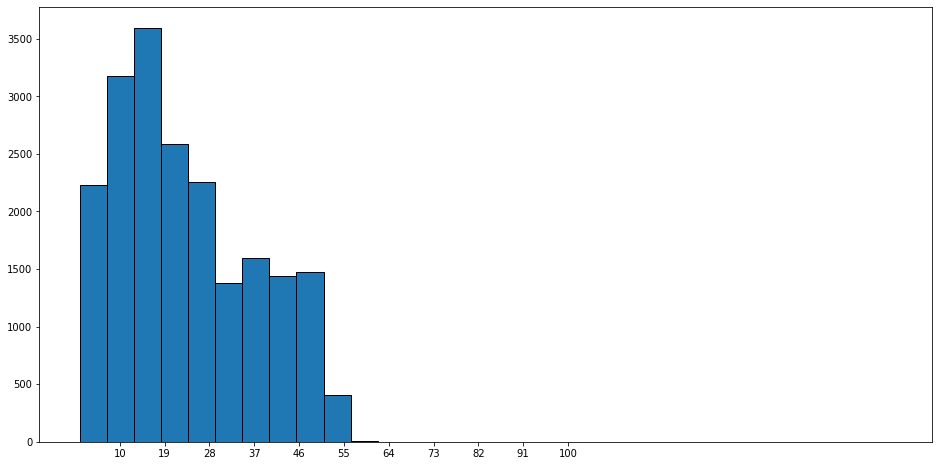

In [17]:
# token lengths distribution in the dataset
token_lengths = [len(i.split()) for i in dataframe["tweet"]]
plt.figure(figsize=(16,8))
plt.hist(token_lengths,bins = 30,edgecolor="black")
plt.xticks(ticks = np.linspace(10,100,11))
plt.show()


In [18]:
# dataframe[dataframe['class']==1].shape,dataframe[dataframe['class']==0].shape,dataframe[dataframe['class']==2].shape

# Training and validation set
We can also consider token length

In [19]:
dataframe["token_length"] = token_lengths
# dataframe = dataframe.loc[dataframe["token_length"] <= 25, :].reset_index(drop=True)



In [20]:
dataframe

,tweet,class,token_length
0,user how can rbi put such limits this has to c...,0.0,22
1,jews and arabs will destroy america,1.0,6
2,included your original post typical kike moves...,1.0,10
3,user in every country where muzzies are in min...,1.0,25
4,would not it be funny if it was a wetback run ...,1.0,47
...,...,...,...
20143,user fam i hate you lot,0.0,6
20144,user user it not homogeneous it just that asia...,2.0,15
20145,lets not as far as im concerned youre a kike w...,1.0,39
20146,these dumbass lahori and islamabadi fuckers ar...,1.0,12


In [21]:
# from sklearn.preprocessing import LabelEncoder
# from keras.utils import np_utils

# encoder = LabelEncoder()
# encoder.fit(dataframe['class'])
# encoded_Y = encoder.transform(dataframe['class'])
# # convert integers to dummy variables (i.e. one hot encoded)
# dummy_y = np_utils.to_categorical(encoded_Y)
# dummy_y


In [22]:
# token_length 128, seems a good fit for data

# split training and validation data
train_df, temp_df = train_test_split(dataframe, test_size= 0.20, stratify= dataframe["class"], random_state = 47)

val_df,   test_df   = train_test_split(temp_df, test_size= 0.80, stratify= temp_df["class"],random_state = 47)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop  = True)
test_df  = test_df.reset_index(drop = True)

#Bert Model

In [23]:
val_df.shape,train_df.shape,test_df.shape

((806, 3), (16118, 3), (3224, 3))

In [24]:
# load bertModel, bertTokenizer and freeze all layers
bertModel = TFAutoModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
bertModel.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [25]:
# dataset generator (for input to tf.data.Dataset.from_generator())

class dataset:

  def __init__(self,text,labels,max_length, tokenizer,projection_dim, val = False):

    self.text =   text
    self.labels = labels
    self.max_length = max_length
    self.tokenizer = tokenizer
    self.flag = val
    self.projection_dim = projection_dim

  def __len__(self):

    return  self.text.shape[0]

  def __getitem__(self,index):

    sentence = self.text[index]
    category = self.labels[index]

    return sentence, category


  # shuffle the dataset after each epoch
  def on_epoch_end(self):

    random_idx = random.sample(list(range(self.__len__())), k = self.__len__())
    self.text   = self.text[random_idx]
    self.labels = self.labels[random_idx]

  def __call__(self):

    for i in range(self.__len__()):
      sentence, label = self.__getitem__(i)
      encodings = self.tokenizer(sentence,
                                 max_length = self.max_length,
                                 padding = "max_length",
                                 truncation = True)

      input_ids  = np.array(encodings["input_ids"])
      masks      = np.array(encodings["attention_mask"])
      ttids      = np.array(encodings["token_type_ids"])

      embedding_index = np.array([i for i in range(self.projection_dim)])
      embedding_index = np.ravel(embedding_index)

      embedding_index = np.tile(embedding_index, (input_ids[0:1].shape[0],))

      yield {"input_ids": input_ids, "attention_masks": masks,"space": embedding_index}, label

      # randomize the dataset on epoch end, only in case of training dataset
      if i == self.__len__() -1 and self.flag is False:
        self.on_epoch_end()

In [26]:
# dataframe[dataframe['class']==1].count(),dataframe[dataframe['class']==0].count()]



# Paramters

In [27]:
# # create generators for train and validation
# train_gen = dataset(train_df["tweet"].values,train_df["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer,projection_dim=PROJECTION_DIM)
# val_gen   = dataset(val_df["tweet"].values,val_df["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)

In [28]:
def dataprep(PROJECTION_DIM):
    train_gen = dataset(train_df["tweet"].values,train_df["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer,projection_dim=PROJECTION_DIM)
    val_gen   = dataset(val_df["tweet"].values,val_df["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)

    train_ds = tf.data.Dataset.from_generator(train_gen,
                                                output_signature =
                                               ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                                tf.TensorSpec(shape = (), dtype = (tf.float32)))).repeat().batch(batch_size = BATCH_SIZE) # shuffling is already implemented in dataset class

    val_ds = tf.data.Dataset.from_generator(val_gen,
                                                output_signature =
                                               ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                                tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

    return train_ds,val_ds

In [29]:
## AUXILLIARY FUNCTIONS

In [44]:
# NA
def return_embedding_index(x_train,count):

    embedding_index=np.array([i for i in range(count)])

    embeding_index=np.ravel(embedding_index) # flattens the array

    rank = len(x_train.shape)
    if rank < 3:
        embedding_index = np.tile(embedding_index,(x_train[0:1].shape[0],1,))
    else:
        embedding_index = np.tile(embedding_index,(x_train.shape[0],1,))

    return embedding_index


# cosine similarity b/w two vectors
def cosine_similarity_projected(vects):

    x,w=vects

    dp = tf.matmul(x, w)


    x_mag = tf.norm(x, axis=2, keepdims = True)

    w_mag = tf.norm(w,axis = 1, keepdims = True)

    denominator = dp / x_mag
    cosine = denominator / w_mag

    return cosine

# NA
def compare_cosine(vector):

    violent,normal=vector

    peace=tf.math.reduce_mean(peace, axis=1)
    violent=tf.math.reduce_mean(violent, axis=1)
    normal=tf.math.reduce_mean(normal, axis=1)
    out=tf.concat([peace,violent,normal],axis=-1)
    print("COMPARE-COSINE")
    print('out.shape')
    print(out.shape)


    return out

# NA
# takes mean embeddings
class remove_pads(tf.keras.layers.Layer):

    def __init__(self,**kwargs):

        super(remove_pads,self).__init__(**kwargs)
        self.mask_generator = layers.Embedding(input_dim = 35000,output_dim = 32, mask_zero=True)



    def call(self,listInputs):

        inputs = listInputs[0]
        input_ids = listInputs[1]
        masks = self.mask_generator.compute_mask(input_ids)
        masks = tf.cast(masks,tf.float32)
        masks = tf.expand_dims(masks,axis=-1)
        temp = tf.unstack(masks,axis=1)
        del temp[0]
        temp.insert(0,tf.zeros_like(temp[0]))
        masks = tf.stack(temp,axis=1)
        length = tf.math.reduce_sum(masks,axis = 1, keepdims=True)     # (None,1,1)
        # mask the embeddings corresponding to zero input id ==0
        masked_embeddings = inputs * masks    # (None,64,300) * (None,64,1) = (None,64,300)
        # take SUM, (not mean)
        masked_embeddings = tf.math.reduce_sum(masked_embeddings, axis = 1, keepdims=True)
        # now just divide each by the length to get mean of non zero embeddings
        masked_embeddings = masked_embeddings / length

        return masked_embeddings



class remove_padsV2(tf.keras.layers.Layer):

    def __init__(self,**kwargs):

        super(remove_padsV2,self).__init__(**kwargs)
        self.mask_generator = layers.Embedding(input_dim = 35000,output_dim = 32, mask_zero=True)  # bert has vocabulary of 30522 words



    def call(self,listInputs):

        inputs = listInputs[0]                   # (None,MAX_LENGTH,PROJECTION_DIM)
        input_ids = listInputs[1]                # (None,MAX_LENGTH)

        # convert token ids 101 and 102 to 0
        filteredInputIds = tf.where(tf.equal(input_ids,101) | tf.equal(input_ids,102),0,input_ids)
        # get masks for input ids
        masks = self.mask_generator.compute_mask(filteredInputIds)
        masks = tf.cast(masks,tf.float32)
        masks = tf.expand_dims(masks,axis=-1)    # (None,MAX_LENGTH,1)

        masked_embeddings = inputs * masks

        return masked_embeddings



# mean embeddings
def merge_function(vects):

    negative,normal = [vects[0], vects[1]]    # (None,MAX_LENGTH,PROJECTION_DIM)


    # of these 128 vectors, those corresponding to tokens [cls, pad, sep] are 0
    # we sum them up and then divide with number of non-zeros to get average cosine similarities
    # positiveLength = tf.math.count_nonzero(tf.math.reduce_sum(positive, axis=2,keepdims=True), axis=1, keepdims=True,dtype = tf.float32)   # (None,1,1)
    negativeLength = tf.math.count_nonzero(tf.math.reduce_sum(negative, axis=2,keepdims=True), axis=1, keepdims=True,dtype = tf.float32)
    normalLength = tf.math.count_nonzero(tf.math.reduce_sum(normal, axis=2,keepdims=True), axis=1, keepdims=True,dtype = tf.float32)


    # now obtain average of cosine similarities
    # positive = tf.math.reduce_sum(positive,axis=1, keepdims=True)    # (None,1,PROJECTION_DIM)
    # positiveAverage = tf.divide(positive, positiveLength)

    negative = tf.math.reduce_sum(negative,axis=1, keepdims=True)    # (None,1,PROJECTION_DIM)
    negativeAverage = tf.divide(negative, negativeLength)

    normal = tf.math.reduce_sum(normal,axis=1, keepdims=True)    # (None,1,PROJECTION_DIM)
    normalAverage = tf.divide(normal, negativeLength)



    # input_shape = (None,1,Projection_DIM)
    res = tf.concat([positiveAverage,negativeAverage,normalAverage], axis = -1)    # (None,1,PROJECTION_DIM)

    return res


# max embeddings
def merge_functionV2(vects):

    negative,normal = vects[0], vects[1], 
    # of these 128 vectors, those corresponding to tokens [cls, pad, sep] are 0


    # TAKE MAXIMUM COSINE SIMILARITY OF ALL THE TOKENS OF A SENTENCE WRT EACH PROJECTION DIM
    # positiveMax = tf.reduce_max(positive, axis=1, keepdims=True)     # (None, 1, PROJECTION_DIM)
    negativeMax = tf.reduce_max(negative, axis=1, keepdims=True)
    normalMax = tf.reduce_max(normal, axis=1, keepdims=True)


    res = tf.concat([negativeMax,normalMax], axis = -1)            # (None,1,  2 * PROJECTION_DIM)

    return res

# increase stdDevLoss in projection dimension
def StdDevLoss(x):                                                              # (None,MAX_LEN,PROJECTION_DIM)

    stdDev = tf.math.reduce_std(x,axis=2)                                         # (None,MAX_LEN)
    stdDevLoss = tf.math.reduce_mean(stdDev)

    return stdDevLoss


Loading Weights

# Model Architecture

In [48]:
# Model Debugging - Rahul
DEBUG = "DEBUG"
# PROJECTION_DIM=10
# for input we have
# 1. input ids
# 2. attention_masks
# 3. embedding_index (PROJECTION_DIM)
# 4. label

def spock_model(MAX_LENGTH,PROJECTION_DIM):
    DEBUG = "DEBUG"
    VECTOR_DIM=768
    # first two will go to bert as input
    ids = layers.Input(shape = (MAX_LENGTH,), dtype = tf.int32, name = "input_ids")
    mks = layers.Input(shape = (MAX_LENGTH,), dtype = tf.int32, name = "attention_masks")
    projection_space = layers.Input(name = "space", shape = (PROJECTION_DIM,))


    input_sentence = bertModel(ids, attention_mask = mks)[0]                        # layers freezed, last_hidden_state_output


#     hate_embedding_layer =  layers.Embedding(name = "hate_embedding",
#                                        input_dim = PROJECTION_DIM,
#                                        output_dim=VECTOR_DIM,
#                                        embeddings_initializer=tf.random_uniform_initializer(minval=-1., maxval=1.),
#                                        input_length = PROJECTION_DIM ,
#                                        # weights=hate_weights,
#                                        trainable=True,
#                                        mask_zero=True)


    offensive_embedding_layer =  layers.Embedding(name = "offensive_embedding",
                                       input_dim=PROJECTION_DIM,
                                       output_dim=VECTOR_DIM,
                                       embeddings_initializer=tf.random_uniform_initializer(minval=-1., maxval=1.),
                                       input_length = PROJECTION_DIM ,
                                       # weights=hate_weights,
                                       trainable=True,
                                       mask_zero=True)


    normal_embedding_layer =  layers.Embedding(name = "normal_embedding",
                                       input_dim=PROJECTION_DIM,
                                       output_dim=VECTOR_DIM,
                                       embeddings_initializer=tf.random_uniform_initializer(minval=-1., maxval=1.),
                                       input_length = PROJECTION_DIM ,
                                       # weights=hate_weights,
                                       trainable=True,
                                       mask_zero=True)


    # embeddings for projection space
    # hate_embedding_np = hate_embedding_layer(projection_space)              # (None,PROJECTION_DIM,VECTOR_DIM)
    offensive_embedding_np = offensive_embedding_layer(projection_space)     # (None,PROJECTION_DIM,VECTOR_DIM)
    normal_embedding_np = normal_embedding_layer(projection_space)     # (None,PROJECTION_DIM,VECTOR_DIM)

    #Permute
    # hate_embedding= layers.Permute((2, 1), input_shape=(PROJECTION_DIM, VECTOR_DIM))(hate_embedding_np)
    offensive_embedding= layers.Permute((2, 1), input_shape=(PROJECTION_DIM, VECTOR_DIM))(offensive_embedding_np)
    normal_embedding= layers.Permute((2, 1), input_shape=(PROJECTION_DIM, VECTOR_DIM))(normal_embedding_np)


    # pos_projection_space
    # hate_cosine = layers.Lambda(function=cosine_similarity_projected,
    #                       name='cosine_hate')([input_sentence, hate_embedding])              # (None,MAX_LENGTH,PROJECTION_DIM)


    # neg_projection_space
    offensive_cosine = layers.Lambda(function=cosine_similarity_projected,
                             name='cosine_offensive')([input_sentence, offensive_embedding])

    # normal_projection_space
    normal_cosine = layers.Lambda(function=cosine_similarity_projected,
                             name='cosine_normal')([input_sentence, normal_embedding])


    # remove paddings from cosines from both layers
    # hate_cosine_nopads = remove_padsV2(name="remove_cls_pad_hate")([hate_cosine, ids])   # (None,MAX_LENGTH,PROJECTION_DIM)
    offensive_cosine_nopads = remove_padsV2(name="remove_cls_pad_offensive")([offensive_cosine, ids])
    normal_cosine_nopads = remove_padsV2(name="remove_cls_pad_normal")([normal_cosine, ids])





    # merge (v1: mean, v2: max)
    merged = layers.Lambda(function=merge_functionV2,
                    name='TakeMaxCosineAndCompare')([offensive_cosine_nopads,normal_cosine_nopads])  # (None,1,1002)    # !these values are not really identical beacause both embedding layers had different random weights

    merged = layers.Flatten(data_format = "channels_first")(merged)


    # CLASSIFICATION HEAD

    # hidden = layers.Dense(612, activation='relu', name = "hidden-1", kernel_constraint=MaxNorm(3),
    #                kernel_initializer = "he_normal")(merged)

    hidden = layers.Dense(256, activation='relu', name = "hidden-1", kernel_constraint=MaxNorm(3),
                   kernel_initializer = "he_normal")(merged)

    # hidden = layers.Dropout(0.6, name="drop-1")(hidden)
    hidden = layers.Dense(64, activation='relu', name = "hidden-2", kernel_constraint=MaxNorm(3),
                   kernel_initializer = "he_normal")(hidden)
    # hidden = layers.Dropout(0.3, name="drop-2")(hidden)
    hidden = layers.Dense(16, activation='relu', name = "hidden-3", kernel_constraint=MaxNorm(3),
                   kernel_initializer= "he_normal")(hidden)
    # hidden = layers.Dropout(0.25, name="drop-3")(hidden)


    predictions = layers.Dense(3, activation= "softmax" , name='classification_layer')(hidden)

    model = Model(inputs=[ids, mks, projection_space],outputs= predictions)
    
    


    offensive_normal_loss = tf.keras.losses.CosineSimilarity(name='offensive_normal_loss')(tf.math.reduce_mean(offensive_cosine, axis=1), tf.math.reduce_mean(normal_cosine, axis=1))
    model.add_loss((1.0/(1.01 + offensive_normal_loss)))


    # # Add the losses to the model with unique names

    model.add_loss((1.0 / (1.01 + offensive_normal_loss)))




    # posStdDevLoss = StdDevLoss(hate_cosine)
    negStdDevLoss = StdDevLoss(offensive_cosine)
    norStdDevLoss = StdDevLoss(normal_cosine)

    # model.add_loss(1.0 / (posStdDevLoss + 0.001))
    # model.add_loss(1.0 / (negStdDevLoss + 0.001))

    # model.add_loss(-1 * posStdDevLoss)
    # model.add_loss(-1 * negStdDevLoss)
    # model.add_loss(-1 * norStdDevLoss)
    # cross entropy loss
    # cross entropy loss
    '''If your 𝑌𝑖
    # 's are one-hot encoded, use categorical_crossentropy. Examples (for a 3-class classification): [1,0,0] , [0,1,0], [0,0,1]
    # But if your 𝑌𝑖
    # 's are integers, use sparse_categorical_crossentropy. "Examples for above 3-class classification problem: [1] , [2], [3]
    crossEntropLoss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)'''

    crossEntropLoss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)



    # optimize can compile
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2, clipnorm = 1.0)
    model.compile(loss = crossEntropLoss , optimizer = optimizer, metrics=["accuracy"])
    return model
    
    

In [49]:
spock_model1= spock_model(30, 120)
spock_model1.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
space (InputLayer)              [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 30)]         0                                            
__________________________________________________________________________________________________
offensive_embedding (Embedding) (None, 120, 768)     92160       space[0][0]                      
____________________________________________________________________________________________

In [ ]:
# # model.summary()

# import tensorflow as tf
# from tensorflow.keras import layers, Model

# class SpockModel(tf.keras.Model):
#     def __init__(self, max_length, projection_dim, vector_dim, bert_model):
#         super(SpockModel, self).__init__()
#         self.max_length = max_length
#         self.projection_dim = projection_dim
#         self.vector_dim = vector_dim
#         self.bert_model = bertModel  # Replace None with your actual BERT model

#     def build(self, input_shape):
#         self.ids = layers.Input(shape=(self.max_length,), dtype=tf.int32, name="input_ids")
#         self.mks = layers.Input(shape=(self.max_length,), dtype=tf.int32, name="attention_masks")
#         self.projection_space = layers.Input(name="space", shape=(self.projection_dim,))

#         self.input_sentence = self.bert_model(self.ids, attention_mask=self.mks)[0]

#         self.hate_embedding_layer = layers.Embedding(
#             name="hate_embedding",
#             input_dim=self.projection_dim,
#             output_dim=self.vector_dim,
#             embeddings_initializer=tf.random_uniform_initializer(minval=-1., maxval=1.),
#             input_length=self.projection_dim,
#             trainable=True,
#             mask_zero=True
#         )
        
#         self.offensive_embedding_layer =  layers.Embedding(
#             name="offensive_embedding",
#             input_dim=self.projection_dim,
#             output_dim=self.vector_dim,
#             embeddings_initializer=tf.random_uniform_initializer(minval=-1., maxval=1.),
#             input_length=self.projection_dim,
#             trainable=True,
#             mask_zero=True
#         )

#         self.normal_embedding_layer = layers.Embedding(
#             name="normal_embedding",
#             input_dim=self.projection_dim,
#             output_dim=self.vector_dim,
#             embeddings_initializer=tf.random_uniform_initializer(minval=-1., maxval=1.),
#             input_length=self.projection_dim,  # Use self.projection_dim
#             trainable=True,
#             mask_zero=True
#         )


#       def call(self, inputs):
#         input_ids, attention_masks, projection_space = inputs

#         hate_embedding_np = self.hate_embedding_layer(projection_space)
#         offensive_embedding_np = self.offensive_embedding_layer(projection_space)     # (None,PROJECTION_DIM,VECTOR_DIM)
#         normal_embedding_np = self.normal_embedding_layer(projection_space)     # (None,PROJECTION_DIM,VECTOR_DIM)


#         # Calculate embeddings for projection space
#         hate_embedding = layers.Permute((2, 1), input_shape=(self.projection_dim, self.vector_dim))(hate_embedding_np)
#         offensive_embedding = layers.Permute((2, 1), input_shape=(self.projection_dim, self.vector_dim))(self.offensive_embedding_layer(offensive_embedding_np))
#         normal_embedding = layers.Permute((2, 1), input_shape=(self.projection_dim, self.vector_dim))(self.normal_embedding_layer(normal_embedding_np))

#         # Calculate cosine similarities
#         hate_cosine = layers.Lambda(cosine_similarity_projected, name='cosine_hate')([self.input_sentence, hate_embedding])
#         offensive_cosine = layers.Lambda(cosine_similarity_projected, name='cosine_offensive')([self.input_sentence, offensive_embedding])
#         normal_cosine = layers.Lambda(cosine_similarity_projected, name='cosine_normal')([self.input_sentence, normal_embedding])

#         # Remove paddings from cosines
#         hate_cosine_nopads = remove_padsV2(name="remove_cls_pad_hate")([hate_cosine, input_ids])
#         offensive_cosine_nopads = remove_padsV2(name="remove_cls_pad_offensive")([offensive_cosine, input_ids])
#         normal_cosine_nopads = remove_padsV2(name="remove_cls_pad_normal")([normal_cosine, input_ids])

#         # Merge (v1: mean, v2: max)
#         merged = layers.Lambda(merge_functionV2, name='TakeMaxCosineAndCompare')([hate_cosine_nopads, offensive_cosine_nopads, normal_cosine_nopads])
#         merged = layers.Flatten(data_format="channels_first")(merged)

#         # Classification head
#         hidden = layers.Dense(256, activation='relu', name="hidden-1", kernel_constraint=MaxNorm(3), kernel_initializer="he_normal")(merged)
#         hidden = layers.Dense(64, activation='relu', name="hidden-2", kernel_constraint=MaxNorm(3), kernel_initializer="he_normal")(hidden)
#         hidden = layers.Dense(16, activation='relu', name="hidden-3", kernel_constraint=MaxNorm(3), kernel_initializer="he_normal")(hidden)
#         predictions = layers.Dense(3, activation="softmax", name='classification_layer')(hidden)

#         return predictions



#     def compile_model(self):
#         # Define your losses, add_loss, and compile the model here
#         # ...
#         hate_normal_loss = tf.keras.losses.CosineSimilarity(name='hate_normal_loss')(tf.math.reduce_mean(hate_cosine, axis=1), tf.math.reduce_mean(normal_cosine, axis=1))
#         model.add_loss((1.0/(1.01 + hate_normal_loss)))

#         hate_offensive_loss = tf.keras.losses.CosineSimilarity(name='hate_offensive_loss')(tf.math.reduce_mean(hate_cosine, axis=1), tf.math.reduce_mean(offensive_cosine, axis=1))
#         model.add_loss((1.0/(1.01 + hate_normal_loss)))

#         offensive_normal_loss = tf.keras.losses.CosineSimilarity(name='offensive_normal_loss')(tf.math.reduce_mean(offensive_cosine, axis=1), tf.math.reduce_mean(normal_cosine, axis=1))
#         model.add_loss((1.0/(1.01 + offensive_normal_loss)))


#         # # Add the losses to the model with unique names
#         model.add_loss((1.0 / (1.01 + hate_normal_loss)))
#         model.add_loss((1.0 / (1.01 + hate_offensive_loss)))
#         model.add_loss((1.0 / (1.01 + offensive_normal_loss)))


#         # increase stdDevLoss in projection dimension
#         def StdDevLoss(x):                                                              # (None,MAX_LEN,PROJECTION_DIM)

#           stdDev = tf.math.reduce_std(x,axis=2)                                         # (None,MAX_LEN)
#           stdDevLoss = tf.math.reduce_mean(stdDev)

#           return stdDevLoss


#         posStdDevLoss = StdDevLoss(hate_cosine)
#         negStdDevLoss = StdDevLoss(offensive_cosine)
#         norStdDevLoss = StdDevLoss(normal_cosine)

#         # model.add_loss(1.0 / (posStdDevLoss + 0.001))
#         # model.add_loss(1.0 / (negStdDevLoss + 0.001))

#         model.add_loss(-1 * posStdDevLoss)
#         model.add_loss(-1 * negStdDevLoss)
#         model.add_loss(-1 * norStdDevLoss)
#         # cross entropy loss
#         # cross entropy loss
#         '''If your 𝑌𝑖
#         # 's are one-hot encoded, use categorical_crossentropy. Examples (for a 3-class classification): [1,0,0] , [0,1,0], [0,0,1]
#         # But if your 𝑌𝑖
#         # 's are integers, use sparse_categorical_crossentropy. "Examples for above 3-class classification problem: [1] , [2], [3]
#         crossEntropLoss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)'''

#         crossEntropLoss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)



#         # optimize can compile
#         optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2, clipnorm = 1.0)
#         model.compile(loss = crossEntropLoss , optimizer = optimizer, metrics=["accuracy"])

# # Example usage:
# max_length = 30  # Replace with your desired max length
# projection_dim = 10  # Replace with your desired projection dimension
# vector_dim = 128  # Replace with your desired vector dimension

# spock_model = SpockModel(max_length, projection_dim, vector_dim)
# spock_model.compile_model()


Loss Function

In [50]:
# BASE_PATH = "/gdrive/Shareddrives/Thesis/"
BATCH_SIZE=16
# BASE_PATH = "/home/naseem_fordham/Spock-paper/Spock_HateXplain"


import os
l=[5,15,30,45,60,80,120]

MAX_LENGTH = 30
BATCH_SIZE = 16
# PROJECTION_DIM =30
VECTOR_DIM = 768
for PROJECTION_DIM in l:
    spock_model1= spock_model(MAX_LENGTH, PROJECTION_DIM)




    BASE_PATH = f"/home/naseem_fordham/Spock-paper/Spock_HateXplain_2CS/CS_{PROJECTION_DIM}"

    train_ds,val_ds=dataprep(PROJECTION_DIM)

    # uncomment while training:
    if not os.path.exists(BASE_PATH):
        os.makedirs(BASE_PATH)

    modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath= f"{BASE_PATH}/CS_{PROJECTION_DIM}.h5",
        monitor = "val_loss",
        verbose = 1,
        save_best_only = True,
        save_weights_only = True,
        mode = "auto",
    )

    earlystopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=5,
        verbose=1,
        mode="auto",
        restore_best_weights=True)

    len(train_df) // BATCH_SIZE

    EPOCHS = 5
    history = spock_model1.fit(
        train_ds,
        steps_per_epoch = len(train_df) // BATCH_SIZE,
        validation_data = val_ds,
        epochs = EPOCHS,
        callbacks = [modelcheckpoint]
    )


    with open(f"{BASE_PATH}/training_history{PROJECTION_DIM}.pkl","wb") as hist:
      pickle.dump(history.history,hist)

Epoch 1/5
1007/1007 [==============================] - 36s 30ms/step - loss: 2.0881 - accuracy: 0.4062 - val_loss: 2.0859 - val_accuracy: 0.4069

Epoch 00001: val_loss improved from inf to 2.08592, saving model to /home/naseem_fordham/Spock-paper/Spock_HateXplain_2CS/CS_5/CS_5.h5
Epoch 2/5
1007/1007 [==============================] - 29s 28ms/step - loss: 2.0833 - accuracy: 0.4073 - val_loss: 2.0830 - val_accuracy: 0.4069

Epoch 00002: val_loss improved from 2.08592 to 2.08302, saving model to /home/naseem_fordham/Spock-paper/Spock_HateXplain_2CS/CS_5/CS_5.h5
Epoch 3/5
1007/1007 [==============================] - 29s 29ms/step - loss: 2.0828 - accuracy: 0.4074 - val_loss: 2.0828 - val_accuracy: 0.4069

Epoch 00003: val_loss improved from 2.08302 to 2.08285, saving model to /home/naseem_fordham/Spock-paper/Spock_HateXplain_2CS/CS_5/CS_5.h5
Epoch 4/5
 378/1007 [==========>...................] - ETA: 17s - loss: 2.0832 - accuracy: 0.4051

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ <ipython-input-50-cbee2a1ef50b>:47 in <module>                                                   │
│                                                                                                  │
│ /home/naseem_fordham/.local/lib/python3.8/site-packages/keras/engine/training.py:1184 in fit     │
│                                                                                                  │
│   1181 │   │   │   │   batch_size=batch_size,                                                    │
│   1182 │   │   │   │   _r=1):                                                                    │
│   1183 │   │   │     callbacks.on_train_batch_begin(step)                                        │
│ ❱ 1184 │   │   │     tmp_logs = self.train_function(iterator)                                    │
│   1185 │   │   │     if data_handler.should_sync:                                                │
│   1186 │   │   │   │   context.async_wait()                                                      │
│   1187 │   │   │     logs = tmp_logs  # No error, now safe to assign to logs.                    │
│                                                                                                  │
│ /usr/lib/python3/dist-packages/tensorflow/python/util/traceback_utils.py:150 in error_handler    │
│                                                                                                  │
│   147 │                                                                                          │
│   148 │   filtered_tb = None                                                                     │
│   149 │   try:                                                                                   │
│ ❱ 150 │     return fn(*args, **kwargs)                                                           │
│   151 │   except Exception as e:                                                                 │
│   152 │     filtered_tb = _process_traceback_frames(e.__traceback__)                             │
│   153 │     raise e.with_traceback(filtered_tb) from None                                        │
│                                                                                                  │
│ /usr/lib/python3/dist-packages/tensorflow/python/eager/def_function.py:915 in __call__           │
│                                                                                                  │
│    912 │     compiler = "xla" if self._jit_compile else "nonXla"                                 │
│    913 │                                                                                         │
│    914 │     with OptionalXlaContext(self._jit_compile):                                         │
│ ❱  915 │   │   result = self._call(*args, **kwds)                                                │
│    916 │                                                                                         │
│    917 │     new_tracing_count = self.experimental_get_tracing_count()                           │
│    918 │     without_tracing = (tracing_count == new_tracing_count)                              │
│                                                                                                  │
│ /usr/lib/python3/dist-packages/tensorflow/python/eager/def_function.py:947 in _call              │
│                                                                                                  │
│    944 │     self._lock.release()                                                                │
│    945 │     # In this case we have created variables on the first call, so we run the           │
│    946 │     # defunned version which is guaranteed to never create variables.                   │
│ ❱  947 │     return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable            │
│    948 │   elif self._stateful_fn is not None:             

# Model Save 

In [ ]:
# convert sigmoid outputs to labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def predictionLabels(i):
     return np.argmax(i, axis=1)

# for PROJECTION_DIM in l:
#     spock_model1= spock_model(MAX_LENGTH, PROJECTION_DIM)
# spock_model1

# BASE_PATH = "/gdrive/Shareddrives/Thesis/"

pattern = r"_([0-9]+)$"


BASE_PATH = f"/home/naseem_fordham/Spock-paper/Spock_Hateoffensive/"

# Iterate over subdirectories
for folder_name in os.listdir(BASE_PATH):
    folder_path = os.path.join(BASE_PATH, folder_name)

    if os.path.isdir(folder_path):
        match = re.search(pattern, folder_name)
        if match:
            model_number = match.group(1)
            print(model_number)
            spock_model2= spock_model(MAX_LENGTH, int(model_number))
            model_filename = os.path.join(folder_path, f"CS_{model_number}.h5")
            print(model_filename)
            
            if os.path.exists(model_filename):
                spock_model2.load_weights(model_filename)
                print(f"Loaded model from {model_filename,model_number}")
                train_ds,val_ds=dataprep(int(model_number))

#             else:
#                 print(f"Model file {model_filename} does not exist.")
#         else:
#             print(f"No number found in folder name {folder_name}")
            
            
            
#             # Calculate the confusion matrix
                predictions = spock_model2.predict(val_ds)
                predictedLabels = predictionLabels(predictions)
                cm = confusion_matrix(val_df['class'].values, predictedLabels)

                # Calculate the confusion matrix as percentages
                cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

                # Create a ConfusionMatrixDisplay for the percentage confusion matrix
                disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['Niether','Hate','Offensive'])  # You should define class_labels
                # HateXplain["label"] = HateXplain["label"].apply(lambda x: 1.0 if x == "hatespeech" else (2.0 if x == "offensive" else 0.0))


                # Plot the confusion matrix as percentages
                disp.plot(cmap=plt.cm.Blues, values_format=".2f")
                plt.show()

            
            # Load the model
        # model = tf.keras.models.load_model(os.path.join(folder_path, "*.h5"))  # Adjust the file name as needed

        # Make predictions with your model
#         predictions = model.predict(your_input_data)  # Replace with your input data

#         # Do something with the predictions, e.g., save or print them
#         print(f"Predictions for model in {folder_name}: {predictions}")


In [ ]:
# UNCOMMENT THIS CELL AFTER MODEL TRAINING

# save model history

with open(f"{BASE_PATH}/training_historyV4.pkl","wb") as hist:
  pickle.dump(history.history,hist)

# history=np.save(f"/home/naseem_fordham/Hate_Xplain/history/C_loss_history_{PROJECTION_DIM}.npy",history.history)

# Load Weights and Model Evaluation

In [ ]:
BASE_PATH = "/home/naseem_fordham/Spock-paper/Spock_HateXplain"
model.load_weights(f"{BASE_PATH}/test3.h5")
history=np.load(f"{BASE_PATH}/training_historyV4.pkl",allow_pickle=True)

In [ ]:
# # BASE_PATH='/home/naseem_fordham/Spock-paper/'
# model.load_weights(f"{BASE_PATH}/Modeltest1.h5")
# history=np.load(f"{BASE_PATH}/training_historyV4.pkl",allow_pickle=True)
# history
# import pickle

# with open('/home/naseem_fordham/Spock-paper/Random_w/Model/training_historyV4.pkl', 'rb') as f:
#     loaded_data = np.load(f,allow_pickle=True)


In [ ]:
# prepare test data for evaluation:
test_gen   = dataset(test_df["tweet"].values,test_df["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)
test_ds = tf.data.Dataset.from_generator(test_gen,
                                            output_signature = 
                                           ({"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

In [ ]:
# convert sigmoid outputs to labels
def predictionLabels(i):
     return np.argmax(i, axis=1)

  # if i < 0.5:
  #   return 0.0
  # else:
  #   return 1.0

# getLabels = np.vectorize(predictionLabels)
predictions = model.predict(test_ds)
predictedLabels = predictionLabels(predictions)

In [ ]:
predictedLabels

In [ ]:
np.argmax(predictions, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
predictedLabels = predictionLabels(predictions)

confusion_matrix(test_df['class'].values, predictedLabels)
ConfusionMatrixDisplay.from_predictions(test_df['class'].values, predictedLabels)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Calculate the confusion matrix
cm = confusion_matrix(test_df['class'].values, predictedLabels)

# Calculate the confusion matrix as percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a ConfusionMatrixDisplay for the percentage confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['0','1','2'])  # You should define class_labels

# Plot the confusion matrix as percentages
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.show()


In [ ]:
import seaborn as sns
# print(classification_report(y_test, predictedLabels))
clf_report = classification_report(test_df['class'],
                                   predictedLabels,
                                   
                                   target_names=[0,1,2],
                                   output_dict=True)


sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(12,8))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy',fontdict = {'fontsize' : 12})
plt.ylim(0,1,0.1)

plt.ylabel('accuracy',fontdict = {'fontsize' : 12})
plt.xlabel('epoch',{'fontsize' : 12})
# plt.ylim(0, ,0.05)
plt.legend(['train', 'val'], loc='upper left',fontsize=12)
plt.title('Training vs Validation accuracy')
# display(plt.show())
# plt.show()

# plt.savefig(f"/home/naseem_fordham/Hate_Xplain//acc.png",dpi=300)
# plt.savefig(f"/home/naseem_fordham/Hate_Xplain/Plots/plots{PROJECTION_DIM}/accu_{PROJECTION_DIM}.png",dpi=300)

#skip: plt.savefig("/gdrive/Shareddrives/Thesis/Results_for_thesis/spock_xhate_acc.png",dpi=300)

plt.figure(figsize=(12,8))
# plt.yticks(np.arange(0,1,step=.1))

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylim(0,3,0.1)

# plt.title('Training loss vs Validation Loss',fontdict = {'fontsize' : 12})
plt.ylabel('loss',fontdict = {'fontsize' : 12})
plt.xlabel('epoch',fontdict = {'fontsize' : 12})
plt.legend(['train', 'val'], loc='upper left',fontsize=12)
plt.title('Training vs Validation loss')

# Lime Explainibity
In this part we are using LIME method to understnd how our model is predicting each word in the senetcen and labeled it as per classification## In this part we are using LIME method to understnd how our model is predicting each word in the senetcen and labeled it as per classification

In [ ]:
# for ele in train_ds.take(1):
#   temp = ele
# temp_iids = temp[0]["input_ids"]
# # temp_mask = temp[0]["attention_masks"]
# temp_iids

In [ ]:
# laoding data set and performning cleaning to ready for feed funtion,
# here we have assigned a tem class to our data set
df_test=pd.read_csv('/home/naseem_fordham/Spock-paper/test.txt',sep='/n', header=None,engine='python')
df_test = df_test.rename(columns={0: 'tweet'})
df_test

df_test["tweet"] = df_test["tweet"].apply(lambda x : text_preprocessing(x))
df_test['class']=1
df_test


In [ ]:
# create generators for train and validation
BATCH_SIZE = 32
# make sure batch size complies with total data set
lime_gen = dataset(df_test["tweet"].values,df_test["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer,projection_dim=PROJECTION_DIM)

# create tensorflow dataloaders from generators
lime_ds = tf.data.Dataset.from_generator(lime_gen,
                                            output_signature =
                                           ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

In [ ]:
# Predict function which will be use later for each text in sentence
def predict_fun(x):
    return model.predict(lime_ds)

In [ ]:
model.predict(lime_ds)

In [ ]:
# for ele in lime_ds.take(1):
#     t=ele


In [ ]:
# from lime.lime_text import LimeTextExplainer

# x=df_test['tweet'][0]
# print(len(x))


# explainer = LimeTextExplainer(class_names=['non_hate','hate'])
# exp=explainer.explain_instance(x, predict_fun, num_features=90, labels=(1,), num_samples=9, distance_metric='cosine')
# exp.show_in_notebook(text=True)

In [ ]:
len(df_test['tweet'].iloc[i].split())

In [ ]:
# Implementing LIME on each sentence
"""Interpretability: If you want highly interpretable explanations that focus on the most salient 
words or terms, you may choose a lower num_features value.

Comprehensiveness: If you want a more comprehensive understanding of why the model made a particular
prediction and are willing to explore a larger number of words or terms, you may choose a higher num_features value."""


''' 0 - hate speech 1 - offensive language 2 - neither'''
from lime.lime_text import LimeTextExplainer
for i in range(1,10):

    x=df_test['tweet'].iloc[i]
    # num=len(df_test['tweet'].iloc[i].split())
    

    explainer = LimeTextExplainer(class_names=['hate','offensive','normal'])
    exp=explainer.explain_instance(x, predict_fun, num_features=6, labels=(0,1), num_samples=10, distance_metric='cosine')
    exp.show_in_notebook(text=True)

# Lime EXplaniation Alternative method

In [ ]:
# for ele in lime_ds.take(0):
#   temp = ele
# temp_iids = temp[0]
# # # temp_mask = temp[0]["attention_masks"]
# temp_iids

In [ ]:
# test_res= list()
# for tweet in df_test['tweet']:
#   tweet = text_preprocessing(tweet)
#   test_res.append(tweet)
#     # print(tweet)

# df_test['tweet'].tolist()

In [ ]:
# # Input_ids=Inputs_test.reshape((Inputs_test.shape[0],1,Inputs_test.shape[1]))
# # bertModel = TFAutoModel.from_pretrained("bert-base-uncased")
# # tokenizer 
# '''In this part we are creating the bert inputs for our model and pass it to the model to predicts the class. 
# Later on we pass this predict model to LIME to underrstand which part of text is more relavent as per our model prediction'''

# from transformers import BertTokenizer, BertModel

# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bmodel = BertModel.from_pretrained("bert-base-uncased")

# import torch
# def predict(x):
#     encoded = tokenizer(
#     text=df_test['tweet'].tolist(),  # the sentence to be encoded
#     add_special_tokens=True,  # Add [CLS] and [SEP]
#     max_length = 45,  # maximum length of a sentence
#     padding='max_length',  # Add [PAD]s
#     return_attention_mask = True,  # Generate the attention mask
#     return_tensors = 'pt',  # ask the function to return PyTorch tensors

#   )
#   # print(encoded)
#     with torch.no_grad():

#         outputs = bmodel(**encoded)

#         # Evaluating the model will return a different number of objects based on 
#         # how it's  configured in the `from_pretrained` call earlier. In this case, 
#         # becase we set `output_hidden_states = True`, the third item will be the 
#         # hidden states from all layers. See the documentation for more details:
#         # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
#         # hidden_states = outputs[2]
#         # violent_hidden_states = violent_outputs[2]

#         last_hidden_states = outputs.last_hidden_state

#     # print(last_hidden_states)

#     x_test=last_hidden_states.numpy()
#     # print(x_test.shape)
#     Inputs_test=encoded['input_ids']
#     # print(Inputs_test.shape)
#     Inputs_test=Inputs_test.reshape((Inputs_test.shape[0],1,Inputs_test.shape[1])).numpy()
#     print(Inputs_test.shape)


#     # print(x_test.shape,Inputs_test.shape)
#     embedding_test=embedding_index[0].reshape(embedding_index[0].shape[0],1)
#     # embedding_test=embedding_index[:30]
#   # embedding_test=embedding_index[:30].reshape(30,embedding_index[:30].shape[1],1)
#   # embedding_test=embedding_index[:10].reshape(10,embedding_index.shape[1])
#   # return model.predict([x_test,Inputs_test,embedding_test])
  
#     # print(embedding_test.shape)
#     print(x_test.shape,Inputs_test.shape,embedding_test.shape)
#     return np.array([[float(1-x), float (x)] for x in model.predict(lime_ds)])
#     # return last_hidden_states
# # model.predict([x_train,Input_ids,embedding_index])

In [ ]:
# def return_embedding_index(count):
  
#   embedding_index=np.array([i for i in range(count)])
#   # embeding_index=np.array([[0,1,2]])
#   embeding_index=np.ravel(embedding_index)

#   embedding_index=np.tile(embedding_index,(len(df_test),1,))
#   # print(embedding_index.shape, type(embeding_index))
#   return embedding_index

# embedding_index = return_embedding_index(PROJECTION_DIM)
# embedding_index.shape

In [ ]:
# from lime.lime_text import LimeTextExplainer

# x=df_test['tweet'][0]
# print(len(x))


# explainer = LimeTextExplainer(class_names=['peace','offensive'])
# exp=explainer.explain_instance(x, predict, num_features=60, labels=(1,), num_samples=9, distance_metric='cosine')
# #num of sample must be same as length of the data set 
# exp.show_in_notebook(text=True)

In [ ]:
# from lime.lime_text import LimeTextExplainer
# for i in range(10):

#     x=df_test['tweet'].iloc[i]

#     explainer = LimeTextExplainer(class_names=['peace','offensive'])
#     exp=explainer.explain_instance(x, predict, num_features=30, labels=(1,), num_samples=9, distance_metric='cosine')
#     #num of sample must be same as length of the data set 
#     exp.show_in_notebook(text=True)

# Model Concept Space

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
import numpy as np
from keras.models import load_model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# model.load_weights(f"{BASE_PATH}/Modeltest1.h5")


hate_layer = model.get_layer('hate_embedding')
hate_embedding = hate_layer.get_weights()
# positive_weights=positive_weights[0].T


offensive_layer = model.get_layer('offensive_embedding')
offensive_embedding = offensive_layer.get_weights()


normal_layer = model.get_layer('normal_embedding')
normal_embedding = normal_layer.get_weights()



In [ ]:

# positive_embedding = model.get_layer('positive_embedding')  # Replace with the name of your layer
# # Get the weights of the specific layer
# positive_embedding = specific_layer.get_weights()
# positive_embedding

In [ ]:
# # model.load_weights(f"{BASE_PATH}/Modeltest1.h5")
# negative_embedding = model.get_layer('negative_embedding')  # Replace with the name of your layer
# # Get the weights of the specific layer
# negative_embedding = specific_layer.get_weights()

In [ ]:
# import numpy as np
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Assuming you have two weight vectors of shape (10, 768)



# # Combine the two weight vectors into one array
# combined_weight_vectors = np.vstack([offensive_embedding[0], hate_embedding[0],normal_embedding[0]])
# tsne = TSNE(n_components=2, perplexity=2, early_exaggeration=12.0, learning_rate=20.0, n_iter=1000)
# # Compute t-SNE embeddings
# # tsne = TSNE(n_components=2, random_state=42)
# tsne_embeddings = tsne.fit_transform(combined_weight_vectors)

# # Separate the t-SNE embeddings for the two weight vectors
# tsne_embeddings1 = tsne_embeddings[:25]  # First weight vector
# tsne_embeddings2 = tsne_embeddings[25:50]  # Second weight vector
# tsne_embeddings3 = tsne_embeddings[50:] 

# # Create a scatter plot for the t-SNE embeddings
# plt.figure(figsize=(8, 6))
# plt.scatter(tsne_embeddings1[:, 0], tsne_embeddings1[:, 1], label='hate_embedding', s=5)
# plt.scatter(tsne_embeddings2[:, 0], tsne_embeddings2[:, 1], label='offensive_embedding', s=5)
# plt.scatter(tsne_embeddings3[:, 0], tsne_embeddings3[:, 1], label='offensive_embedding', s=5)
# # plt.scatter(tsne_embeddings2[:, 0], tsne_embeddings2[:, 1], label='normal_embedding', s=5)

# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.legend()
# plt.title('t-SNE Visualization of Weight Vectors')
# plt.show()


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module

# Assuming you have three weight vectors of shape (10, 768)

# Combine the three weight vectors into one array
combined_weight_vectors = np.vstack([hate_embedding[0], offensive_embedding[0], normal_embedding[0]])
tsne = TSNE(n_components=3, perplexity=50, early_exaggeration=12.0, learning_rate=50.0, n_iter=10000)

# Compute t-SNE embeddings
tsne_embeddings = tsne.fit_transform(combined_weight_vectors)

# Separate the t-SNE embeddings for the three weight vectors
tsne_embeddings1 = tsne_embeddings[:25]        # First weight vector (hate)
tsne_embeddings2 = tsne_embeddings[25:50]      # Second weight vector (offensive)
tsne_embeddings3 = tsne_embeddings[50:]        # Third weight vector (normal)

# Create a 3D scatter plot for the t-SNE embeddings
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

ax.scatter(tsne_embeddings1[:, 0], tsne_embeddings1[:, 1], tsne_embeddings1[:, 2], label='hate_embedding', s=5)
ax.scatter(tsne_embeddings2[:, 0], tsne_embeddings2[:, 1], tsne_embeddings2[:, 2], label='offensive_embedding', s=5)
ax.scatter(tsne_embeddings3[:, 0], tsne_embeddings3[:, 1], tsne_embeddings3[:, 2], label='normal_embedding', s=5)

ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.legend()
plt.title('3D t-SNE Visualization of Weight Vectors')
plt.show()
